## DPA on Firmaware Implementation of AES

 Remember, this works due to the S-Box being present in the data flow that we are attacking.

*We'll see how to use power analysis instead of an actual bit value. With this technique, the goal is to separate the traces by a bit in the result of the SBox output (it doesn't matter which one): if that bit is 1, its group of traces should, on average, have higher power consumption during the SBox operation than the other set.*

*This is all based on the assumption that there is some consistent relationship between the value of bits on the data bus and the power consumption in the device (This works due to the S-Box being present in the data flow that we are attacking.).*

**GOALS:**

* Using a power measurement to 'validate' a possible device model.
* Detecting the value of a single bit using power measurement.
* Breaking AES using the classic DPA attack.

In [1]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

In [2]:
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


In [4]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'AVRCRYPTOLIB'
SS_VER = 'SS_VER_1_1'

In [5]:
%run 'Setup_Scripts/Setup_Generic.ipynb'

INFO: Found ChipWhisperer😍


In [6]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWLITEXMEGA with CRYPTO_TARGET=AVRCRYPTOLIB
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s aes-independant.s aes_enc.s aes_keyschedule.s aes_sbox.s aes128_enc.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d aes-independant.d aes_enc.d aes_keyschedule.d aes_sbox.d aes128_enc.d
rm -f -- simpleserial-aes.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i aes-independant.i aes_enc.i aes_keyschedule.i aes_sbox.i aes128_enc.i
.
Welcome

In [7]:
fw_path = "../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM)

In [8]:
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3761 bytes


### AES Power Watcher

The next step is to send random data to the device, and observe the power consumption during the encryption.

The idea is that we will use a capture loop like this:

In [9]:
from tqdm import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)

N = 5000
for i in trange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

Capturing traces: 100%|██████████| 5000/5000 [02:14<00:00, 37.27it/s]


In [10]:
assert(len(trace_array) == 5000)
print("✔️ OK to continue!")

✔️ OK to continue!


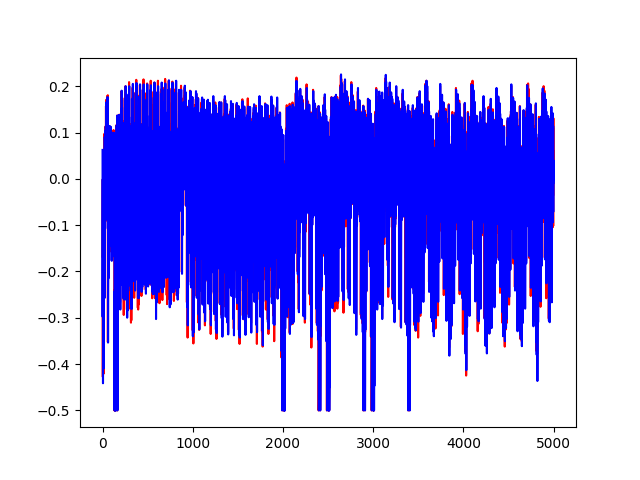

In [11]:
%matplotlib ipympl
import matplotlib.pylab as plt

plt.figure()
plt.plot(trace_array[0], 'red')
plt.plot(trace_array[1], 'blue')
plt.show()

In [12]:
print(textin_array[0])
print(textin_array[1])

CWbytearray(b'70 40 ab 7c 9b 6a 00 92 29 11 76 2b 36 02 ee 72')
CWbytearray(b'20 7d 80 46 b4 0a 08 90 92 fd 44 22 28 b9 48 ba')


In [13]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace
print(numtraces, numpoints)

5000 5000


#### Guessing one byte (the first one) using a single bit and the SAD

The attack now needs a way of splitting traces into two groups, depending on the state of a bit in our "guessed" value. We're going to start easy by guessing a single byte of the AES key at a time.



The important thing here is the `axis=0`, which does an average so the resulting array is done across all traces (not just the average value of one trace, but the average of each point index *across all traces*).

Let me tell you that the correct value of byte 0 is `0x2B`. 
What you should see is an output of the maximum value between the two average groups be higher for the `0x2B` value

In digital image processing, the sum of absolute differences (SAD) is a measure of the similarity between image blocks. It is calculated by taking the absolute difference between each pixel in the original block and the corresponding pixel in the block being used for comparison. These differences are summed to create a simple metric of block similarity, the L1 norm of the difference image or Manhattan distance between two image blocks.

The sum of absolute differences may be used for a variety of purposes, such as object recognition, the generation of disparity maps for stereo images, and motion estimation for video compression.
[SAD](https://en.wikipedia.org/wiki/Sum_of_absolute_differences)

In [14]:
import numpy as np
mean_diffs = np.zeros(256)
for guess in range(256):
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        input_byte = textin_array[trace_index][0]

        hypothetical_leakage = aes_internal(key=guess, inputdata=input_byte)

        if hypothetical_leakage & 0x01:
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])
    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)

    mean_diffs[guess] = np.max(abs(one_avg - zero_avg))
    print('Guessing {:0X}: {:f}'.format(guess, mean_diffs[guess]))

Guessing 0: 0.004616
Guessing 1: 0.003608
Guessing 2: 0.003661
Guessing 3: 0.002804
Guessing 4: 0.003664
Guessing 5: 0.003710
Guessing 6: 0.003665
Guessing 7: 0.004485
Guessing 8: 0.005142
Guessing 9: 0.002516
Guessing A: 0.004631
Guessing B: 0.003374
Guessing C: 0.004106
Guessing D: 0.002883
Guessing E: 0.003190
Guessing F: 0.001862
Guessing 10: 0.002521
Guessing 11: 0.003081
Guessing 12: 0.002686
Guessing 13: 0.003695
Guessing 14: 0.003887
Guessing 15: 0.005390
Guessing 16: 0.004189
Guessing 17: 0.002885
Guessing 18: 0.003052
Guessing 19: 0.003943
Guessing 1A: 0.003066
Guessing 1B: 0.003665
Guessing 1C: 0.003901
Guessing 1D: 0.003833
Guessing 1E: 0.004017
Guessing 1F: 0.003841
Guessing 20: 0.005378
Guessing 21: 0.003953
Guessing 22: 0.005442
Guessing 23: 0.004572
Guessing 24: 0.003101
Guessing 25: 0.002378
Guessing 26: 0.003511
Guessing 27: 0.002793
Guessing 28: 0.003351
Guessing 29: 0.002374
Guessing 2A: 0.004208
Guessing 2B: 0.009403
Guessing 2C: 0.003006
Guessing 2D: 0.004552
Gues

In [15]:
sorted_list = np.argsort(mean_diffs)[::-1]

for guess in sorted_list[0:5]:
    print('Guess {:0X}: {:1f}'.format(guess, mean_diffs[guess]))

Guess 2B: 0.009403
Guess 4A: 0.006081
Guess 35: 0.006079
Guess BD: 0.006054
Guess 96: 0.006052


In [16]:
key

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')

### AES Guesser - All Bytes

In [17]:
def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

In [18]:
from tqdm import trange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

full_diffs_list = []

for subkey in trange(0, 16, desc="Attacking Subkey"):
    max_individual_diffs = [0] * 256
    full_diffs = [0] * 256
    for guess in range(256):
        diffs = calculate_diffs(guess,byteindex=subkey, bitnum=0)
        max_individual_diffs[guess] = np.max(diffs)
        full_diffs[guess] = diffs

    top_diffs = np.argsort(max_individual_diffs)[::-1]
        
    key_guess.append(top_diffs[0])

    full_diffs_list.append(full_diffs[:])
    print('Subkey {:d} - most likely {:X} (actual {:X})'.format(subkey, top_diffs[0], known_key[subkey]))

    print("Top 5 guesses:")
    for g in top_diffs[0:5]:
        print('{:0X} - Diff = {:f}'.format(g, max_individual_diffs[g])) 
        

Attacking Subkey:   6%|▋         | 1/16 [00:19<04:50, 19.38s/it]

Subkey 0 - most likely 2B (actual 2B)
Top 5 guesses:
2B - Diff = 0.009403
4A - Diff = 0.006081
35 - Diff = 0.006079
BD - Diff = 0.006054
96 - Diff = 0.006052


Attacking Subkey:  12%|█▎        | 2/16 [00:36<04:14, 18.20s/it]

Subkey 1 - most likely 7E (actual 7E)
Top 5 guesses:
7E - Diff = 0.013735
92 - Diff = 0.009957
14 - Diff = 0.009018
AE - Diff = 0.008973
B4 - Diff = 0.008486


Attacking Subkey:  19%|█▉        | 3/16 [00:54<03:53, 17.97s/it]

Subkey 2 - most likely 15 (actual 15)
Top 5 guesses:
15 - Diff = 0.009844
81 - Diff = 0.004935
88 - Diff = 0.004822
83 - Diff = 0.004794
7E - Diff = 0.004770


Attacking Subkey:  25%|██▌       | 4/16 [01:12<03:37, 18.14s/it]

Subkey 3 - most likely 16 (actual 16)
Top 5 guesses:
16 - Diff = 0.016015
7D - Diff = 0.005837
53 - Diff = 0.005378
A0 - Diff = 0.005308
7B - Diff = 0.005165


Attacking Subkey:  31%|███▏      | 5/16 [01:29<03:15, 17.76s/it]

Subkey 4 - most likely 28 (actual 28)
Top 5 guesses:
28 - Diff = 0.009816
B4 - Diff = 0.006740
43 - Diff = 0.006682
B0 - Diff = 0.006438
41 - Diff = 0.006222


Attacking Subkey:  38%|███▊      | 6/16 [01:49<03:02, 18.25s/it]

Subkey 5 - most likely AE (actual AE)
Top 5 guesses:
AE - Diff = 0.011211
37 - Diff = 0.006002
B1 - Diff = 0.005335
B6 - Diff = 0.004868
1A - Diff = 0.004744


Attacking Subkey:  44%|████▍     | 7/16 [02:08<02:48, 18.70s/it]

Subkey 6 - most likely 3E (actual D2)
Top 5 guesses:
3E - Diff = 0.010703
D2 - Diff = 0.010116
2 - Diff = 0.009943
31 - Diff = 0.009594
18 - Diff = 0.008695


Attacking Subkey:  50%|█████     | 8/16 [02:26<02:27, 18.44s/it]

Subkey 7 - most likely A6 (actual A6)
Top 5 guesses:
A6 - Diff = 0.009944
9C - Diff = 0.004940
3F - Diff = 0.004826
7C - Diff = 0.004756
4A - Diff = 0.004625


Attacking Subkey:  56%|█████▋    | 9/16 [02:44<02:06, 18.13s/it]

Subkey 8 - most likely AB (actual AB)
Top 5 guesses:
AB - Diff = 0.009475
3F - Diff = 0.004855
AD - Diff = 0.004761
1F - Diff = 0.004720
B7 - Diff = 0.004452


Attacking Subkey:  62%|██████▎   | 10/16 [03:00<01:45, 17.63s/it]

Subkey 9 - most likely F7 (actual F7)
Top 5 guesses:
F7 - Diff = 0.010482
6E - Diff = 0.006344
5 - Diff = 0.004936
3C - Diff = 0.004904
4A - Diff = 0.004878


Attacking Subkey:  69%|██████▉   | 11/16 [03:19<01:30, 18.16s/it]

Subkey 10 - most likely 15 (actual 15)
Top 5 guesses:
15 - Diff = 0.014418
7E - Diff = 0.007421
A8 - Diff = 0.007049
F9 - Diff = 0.006250
87 - Diff = 0.005856


Attacking Subkey:  75%|███████▌  | 12/16 [03:38<01:13, 18.35s/it]

Subkey 11 - most likely 64 (actual 88)
Top 5 guesses:
64 - Diff = 0.009393
42 - Diff = 0.009313
88 - Diff = 0.008955
B6 - Diff = 0.008714
58 - Diff = 0.008604


Attacking Subkey:  81%|████████▏ | 13/16 [03:56<00:54, 18.04s/it]

Subkey 12 - most likely 9 (actual 9)
Top 5 guesses:
9 - Diff = 0.009826
9D - Diff = 0.006282
60 - Diff = 0.006272
9C - Diff = 0.005900
94 - Diff = 0.005828


Attacking Subkey:  88%|████████▊ | 14/16 [04:13<00:35, 17.93s/it]

Subkey 13 - most likely CF (actual CF)
Top 5 guesses:
CF - Diff = 0.009622
BE - Diff = 0.005826
7B - Diff = 0.005188
24 - Diff = 0.004764
22 - Diff = 0.004554


Attacking Subkey:  94%|█████████▍| 15/16 [04:30<00:17, 17.58s/it]

Subkey 14 - most likely 4F (actual 4F)
Top 5 guesses:
4F - Diff = 0.009517
F2 - Diff = 0.005289
FB - Diff = 0.005213
DB - Diff = 0.005091
26 - Diff = 0.005077


Attacking Subkey: 100%|██████████| 16/16 [04:47<00:00, 17.98s/it]

Subkey 15 - most likely 3C (actual 3C)
Top 5 guesses:
3C - Diff = 0.011519
2 - Diff = 0.005241
3A - Diff = 0.005181
22 - Diff = 0.005041
EC - Diff = 0.004953


### Ghost Peaks
Maybe the previous didn't actually recover the full key? No need to worry - there are a few reasons for this. One artifact of a DPA attack is you get another strong peak that isn't the correct key (which can be a ghost peak).

We're going to get into more efficient attacks later, but for now, let's look at some solutions:

* Increase the number of traces recorded.
* Change the targetted bit (& combine solutions from multiple bits).

The first one is the brute-force option: go from 2500 to 5000 or even 10000 power traces. As you add more data, you may find the problem is reduced. But real ghost peaks may not disappear, so we need to move onto other solutions.

Before we begin - we're going to give you a "known good" DPA attack script we're going to build on. This uses the `calculate_diffs()` function defined earlier.

#### Combine Multiple Bits fir each key byte

In [19]:
def calculate_diffs(guess, byteindex=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    
    grouped_byte_traces = []
    for bit in range(8):
        grouped_bit_traces = [], []
        for trace_index in range(numtraces):
            hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

            #Mask off the requested bit
            if hypothetical_leakage & (1<<bit):
                grouped_bit_traces[0].append(trace_array[trace_index])
            else:
                grouped_bit_traces[1].append(trace_array[trace_index])

        grouped_byte_traces.append(grouped_bit_traces)
    diffs = []
    for i in range(8):
        means = np.average(grouped_byte_traces[i][0], axis=0), np.average(grouped_byte_traces[i][1], axis=0)
        diffs.append(abs(means[1] - means[0]))
    
    return np.array(diffs)

In [20]:
from tqdm import trange
import numpy as np

#Store your key_guess here, then compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

full_diffs_list = []

for subkey in trange(0, 16, desc="Attacking Subkey"):

    max_individual_diffs = [0] * 256
    full_diffs = [0] * 256
    for guess in range(256):
        diffs = calculate_diffs(guess,byteindex=subkey)
        max_individual_diffs[guess] = np.max(diffs)
        full_diffs[guess] = diffs

    top_diffs = np.argsort(max_individual_diffs)[::-1]
        
    key_guess.append(top_diffs[0])

    full_diffs_list.append(full_diffs[:])
    print('Subkey {:d} - most likely {:X} (actual {:X})'.format(subkey, top_diffs[0], known_key[subkey]))

    print("Top 5 guesses:")
    for g in top_diffs[0:5]:
        print('{:0X} - Diff = {:f}'.format(g, max_individual_diffs[g])) 
        

Attacking Subkey:   6%|▋         | 1/16 [02:05<31:28, 125.91s/it]

Subkey 0 - most likely 2B (actual 2B)
Top 5 guesses:
2B - Diff = 0.018562
8C - Diff = 0.007552
EC - Diff = 0.007477
0 - Diff = 0.007337
E4 - Diff = 0.007112


Attacking Subkey:  12%|█▎        | 2/16 [04:10<29:08, 124.91s/it]

Subkey 1 - most likely 7E (actual 7E)
Top 5 guesses:
7E - Diff = 0.058893
40 - Diff = 0.011006
37 - Diff = 0.010804
BF - Diff = 0.010459
F3 - Diff = 0.010383


Attacking Subkey:  19%|█▉        | 3/16 [06:14<26:59, 124.57s/it]

Subkey 2 - most likely 15 (actual 15)
Top 5 guesses:
15 - Diff = 0.015212
82 - Diff = 0.006784
2D - Diff = 0.006657
25 - Diff = 0.006548
C2 - Diff = 0.006514


Attacking Subkey:  25%|██▌       | 4/16 [08:18<24:53, 124.44s/it]

Subkey 3 - most likely 16 (actual 16)
Top 5 guesses:
16 - Diff = 0.016621
8 - Diff = 0.007234
C - Diff = 0.007039
FB - Diff = 0.007034
A7 - Diff = 0.006980


Attacking Subkey:  31%|███▏      | 5/16 [10:22<22:47, 124.36s/it]

Subkey 4 - most likely 28 (actual 28)
Top 5 guesses:
28 - Diff = 0.011131
FD - Diff = 0.008061
A7 - Diff = 0.007864
FF - Diff = 0.007773
85 - Diff = 0.007749


Attacking Subkey:  38%|███▊      | 6/16 [12:27<20:43, 124.36s/it]

Subkey 5 - most likely AE (actual AE)
Top 5 guesses:
AE - Diff = 0.012546
39 - Diff = 0.006821
38 - Diff = 0.005939
DE - Diff = 0.005807
7E - Diff = 0.005807


Attacking Subkey:  44%|████▍     | 7/16 [14:31<18:38, 124.32s/it]

Subkey 6 - most likely D2 (actual D2)
Top 5 guesses:
D2 - Diff = 0.058608
9B - Diff = 0.011540
9 - Diff = 0.011102
3F - Diff = 0.010059
3E - Diff = 0.010030


Attacking Subkey:  50%|█████     | 8/16 [16:40<16:46, 125.83s/it]

Subkey 7 - most likely A6 (actual A6)
Top 5 guesses:
A6 - Diff = 0.011732
C2 - Diff = 0.006093
31 - Diff = 0.006066
A7 - Diff = 0.005955
52 - Diff = 0.005726


Attacking Subkey:  56%|█████▋    | 9/16 [18:34<14:14, 122.06s/it]

Subkey 8 - most likely AB (actual AB)
Top 5 guesses:
AB - Diff = 0.009448
3C - Diff = 0.006443
6A - Diff = 0.005773
93 - Diff = 0.005612
79 - Diff = 0.005603


Attacking Subkey:  62%|██████▎   | 10/16 [20:29<12:00, 120.01s/it]

Subkey 9 - most likely F7 (actual F7)
Top 5 guesses:
F7 - Diff = 0.013327
27 - Diff = 0.006913
6E - Diff = 0.006619
60 - Diff = 0.006291
F6 - Diff = 0.005893


Attacking Subkey:  69%|██████▉   | 11/16 [22:31<10:02, 120.51s/it]

Subkey 10 - most likely 15 (actual 15)
Top 5 guesses:
15 - Diff = 0.015992
3 - Diff = 0.008199
C5 - Diff = 0.007827
9C - Diff = 0.007607
9 - Diff = 0.007593


Attacking Subkey:  75%|███████▌  | 12/16 [24:36<08:07, 121.89s/it]

Subkey 11 - most likely 88 (actual 88)
Top 5 guesses:
88 - Diff = 0.058256
C1 - Diff = 0.011266
5 - Diff = 0.010055
78 - Diff = 0.010012
49 - Diff = 0.009887


Attacking Subkey:  81%|████████▏ | 13/16 [26:41<06:08, 122.94s/it]

Subkey 12 - most likely 9 (actual 9)
Top 5 guesses:
9 - Diff = 0.009849
31 - Diff = 0.007867
21 - Diff = 0.007525
2A - Diff = 0.007162
C7 - Diff = 0.007155


Attacking Subkey:  88%|████████▊ | 14/16 [28:42<04:04, 122.20s/it]

Subkey 13 - most likely CF (actual CF)
Top 5 guesses:
CF - Diff = 0.010271
58 - Diff = 0.006416
D9 - Diff = 0.005804
F6 - Diff = 0.005647
CE - Diff = 0.005585


Attacking Subkey:  94%|█████████▍| 15/16 [30:47<02:03, 123.11s/it]

Subkey 14 - most likely 4F (actual 4F)
Top 5 guesses:
4F - Diff = 0.012265
74 - Diff = 0.006452
D8 - Diff = 0.006232
4E - Diff = 0.005688
B8 - Diff = 0.005452


Attacking Subkey: 100%|██████████| 16/16 [32:54<00:00, 123.42s/it]

Subkey 15 - most likely 3C (actual 3C)
Top 5 guesses:
3C - Diff = 0.014772
D1 - Diff = 0.007600
B1 - Diff = 0.007157
F3 - Diff = 0.007133
CC - Diff = 0.006583
